In [328]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import cupy as cp
import cuml
import sklearn

# Splitting Data into Train/Test

In [329]:
df = pd.read_csv('./diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [330]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=22)

print("Training dimesion: " + str(x_train.shape) + " "  + str(y_train.shape))
print("Test: " + str(x_test.shape) + " "  + str(x_test.shape))

Training dimesion: (56553, 21) (56553,)
Test: (14139, 21) (14139, 21)


## EDA

In [331]:
# Merge back into one dataframe for EDA
df = pd.DataFrame(x_train)
df.insert(0, "Diabetes_binary", y_train)
df.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
39727,1.0,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,4.0,5.0
21136,0.0,0.0,0.0,1.0,35.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,3.0,30.0,15.0,0.0,0.0,5.0,5.0,5.0
3591,0.0,0.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,11.0,6.0,6.0
12127,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
34337,0.0,0.0,0.0,1.0,38.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,1.0,1.0,10.0,6.0,8.0


In [332]:
df.shape

(56553, 22)

In [333]:
df.dtypes

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

All columns of the data are numerical, which is good for us when we're building models.

The data is perfectly balanced with 50% of each class. A baseline model would only guess correctly 50% of the time.

For that reason, any performance gain pass 50% could be considered significant.

An informed idea from experienced doctors could be very lengthy process. With the help of Machine Learning modelling, we could train a model to predict (roughly) the chances of being diabete relatively painless and rather quickly.

In [334]:
df.corr()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_binary,1.000000,0.376964,0.289631,0.114207,0.291798,0.084353,0.125771,0.209570,-0.157727,-0.054429,...,0.019334,0.043752,0.407267,0.088467,0.212429,0.270664,0.043990,0.277130,-0.168152,-0.225387
HighBP,0.376964,1.000000,0.314519,0.102380,0.241346,0.087404,0.130245,0.212322,-0.138408,-0.039185,...,0.035262,0.027415,0.318967,0.065371,0.171091,0.233226,0.040451,0.337489,-0.141583,-0.188915
HighChol,0.289631,0.314519,1.000000,0.086992,0.132418,0.096699,0.099042,0.181425,-0.091646,-0.045984,...,0.031301,0.033788,0.237393,0.084570,0.142138,0.165802,0.015837,0.239719,-0.087379,-0.108621
CholCheck,0.114207,0.102380,0.086992,1.000000,0.044614,0.002200,0.024113,0.044580,-0.007505,0.009708,...,0.099270,-0.055814,0.059744,-0.011902,0.034655,0.041699,-0.005741,0.102343,-0.012353,0.003658
BMI,0.291798,0.241346,0.132418,0.044614,1.000000,0.011592,0.023371,0.060728,-0.169640,-0.086696,...,-0.014491,0.068446,0.266666,0.108572,0.163866,0.243651,-0.000125,-0.038444,-0.101172,-0.128307
Smoker,0.084353,0.087404,0.096699,0.002200,0.011592,1.000000,0.063909,0.124813,-0.078615,-0.074320,...,-0.010419,0.035268,0.153618,0.090703,0.118120,0.119204,0.113418,0.105822,-0.138439,-0.103361
Stroke,0.125771,0.130245,0.099042,0.024113,0.023371,0.063909,1.000000,0.226891,-0.079733,-0.009368,...,0.007296,0.033205,0.186144,0.085285,0.158451,0.189189,0.004968,0.120977,-0.074635,-0.134853
HeartDiseaseorAttack,0.209570,0.212322,0.181425,0.044580,0.060728,0.124813,0.226891,1.000000,-0.099056,-0.020113,...,0.016003,0.035162,0.276475,0.074334,0.195628,0.232799,0.098277,0.222926,-0.097046,-0.147634
PhysActivity,-0.157727,-0.138408,-0.091646,-0.007505,-0.169640,-0.078615,-0.079733,-0.099056,1.000000,0.132159,...,0.026004,-0.062192,-0.274502,-0.131285,-0.236753,-0.278581,0.050210,-0.100950,0.190979,0.195479
Fruits,-0.054429,-0.039185,-0.045984,0.009708,-0.086696,-0.074320,-0.009368,-0.020113,0.132159,1.000000,...,0.028151,-0.046547,-0.098750,-0.062568,-0.047759,-0.050546,-0.084587,0.059683,0.099264,0.082559


A few interesting correlations:

Diabetes have high positive correlation with:
- High blood pressure
- High Cholesterol
- General Health (self-evaluation)
- Difficulty Walking
- Physical Health for the past 30 days
- BMI
- Age
- Heart Disease or Attack

Diabetes have high negative correlation with:
- Income

<AxesSubplot:xlabel='Age', ylabel='BMI'>

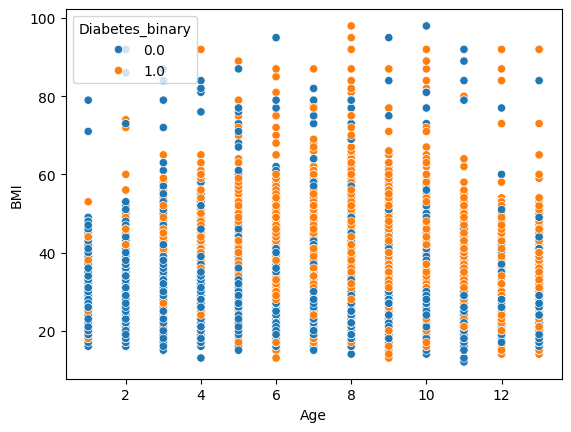

In [335]:
sns.scatterplot(data=df, x='Age', y='BMI', hue='Diabetes_binary')

<AxesSubplot:xlabel='Age', ylabel='BMI'>

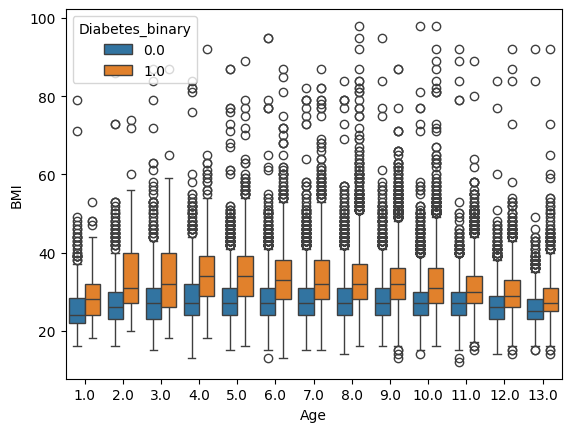

In [336]:
sns.boxplot(data=df, x='Age', y='BMI', hue='Diabetes_binary')

We can see that at every age group, there's always people with higher BMI weights than the norm.

A general trend that we can see here is that people who have higher BMI at their age group usually has diabetes.

<AxesSubplot:xlabel='HighBP', ylabel='HighChol'>

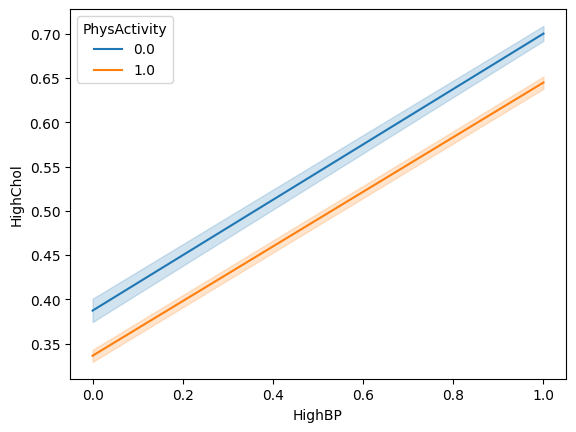

In [337]:
sns.lineplot(data=df, x='HighBP', y='HighChol', hue='PhysActivity')

People with less activity tend to have higher Cholesterol and Blood Pressure than those who regularly exercise. The difference is substantial.

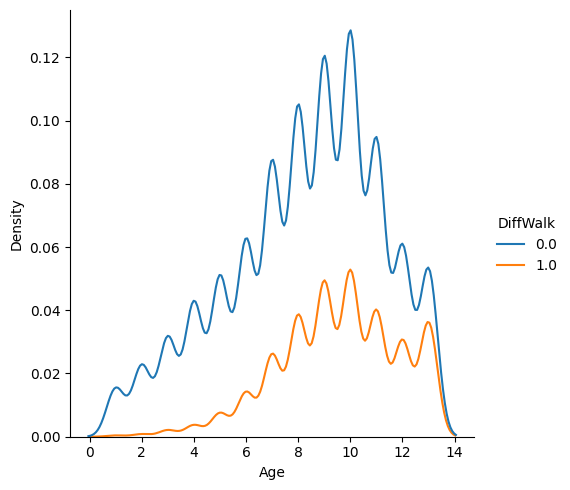

In [338]:
sns.displot(data=df, x='Age', hue='DiffWalk', kind='kde')

<AxesSubplot:xlabel='Fruits', ylabel='Age'>

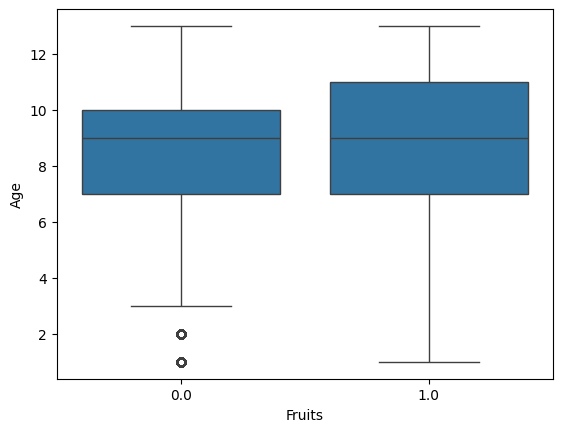

In [339]:
sns.boxplot(data=df, x='Fruits', y='Age')

it looks like fruit is just prefrence i.e doesn't have any relationship between age and fruit

<AxesSubplot:ylabel='Age'>

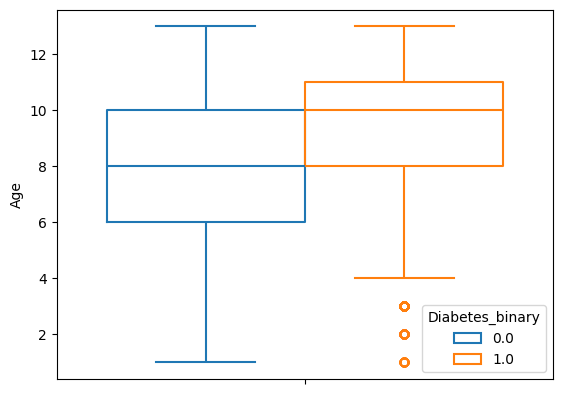

In [340]:
sns.boxplot(data=df, y='Age', fill=False, hue='Diabetes_binary')

<AxesSubplot:xlabel='Education', ylabel='PhysActivity'>

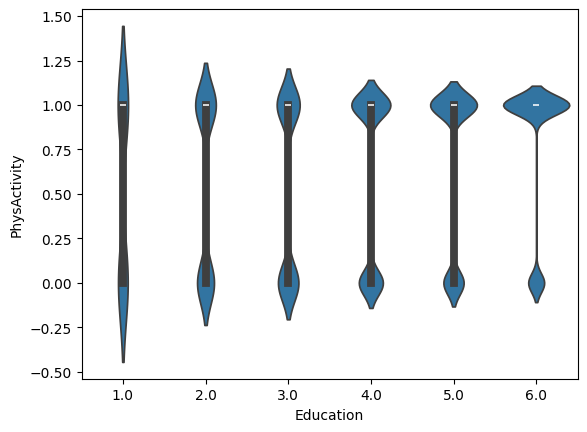

In [341]:
sns.violinplot(data=df, x='Education', y='PhysActivity')

<AxesSubplot:xlabel='Diabetes_binary', ylabel='PhysActivity'>

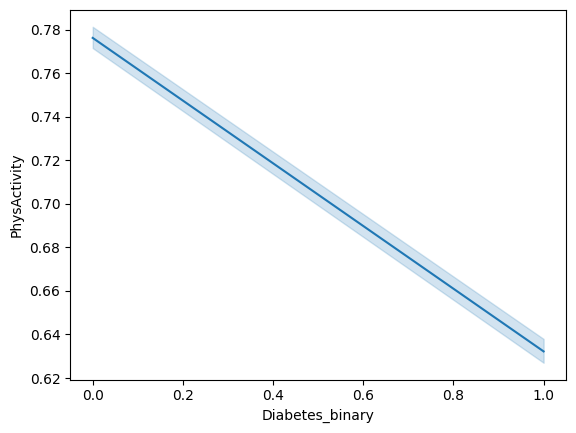

In [342]:
sns.lineplot(data=df, x='Diabetes_binary', y='PhysActivity')

Except for younger ages (earlier education group), people tend to spend more time and effort exercising. This might be due to the fact that the significance of exercising have been shown in many areas of study.

From the earlier plots, we can see that less activity can be an indicator of Diabetes. A better way to say it would be because of the lack of exercise, one have a higher chance of being diagnosed with Diabetes.

# NVIDIA Rapids GPU Acceleration

In [303]:
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifierSK
from cuml.ensemble import RandomForestClassifier as RandomForestClassifierRapid
from cuml.metrics import accuracy_score

In [316]:
n_estimators = [10, 100, 1000]

sk_time = []
rapid_time = []

sk_acc = []
rapid_acc = []

for num_trees in n_estimators:
    RF_sk = RandomForestClassifierSK(n_estimators=num_trees, criterion='entropy', max_depth=15)
    RF_rapid = RandomForestClassifierRapid(n_estimators=num_trees, split_criterion=1, max_depth=15)

    start = time.time()
    RF_sk.fit(x_train.get(), y_train.get())
    end = time.time()
    sk_time.append(end - start)

    start = time.time()
    RF_rapid.fit(x_train, y_train)
    end = time.time()
    rapid_time.append(end - start)
    
    sk_acc.append(accuracy_score(y_test, RF_sk.predict(x_test.get())))
    rapid_acc.append(accuracy_score(y_test, RF_rapid.predict(x_test)))

/home/jv/miniconda3/envs/rapids-24.04/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/jv/miniconda3/envs/rapids-24.04/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/jv/miniconda3/envs/rapids-24.04/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [344]:
# Number from BigQUery notebook
bigml_time = [81.5, 112.5]
bigml_acc = [0.73, 0.73]

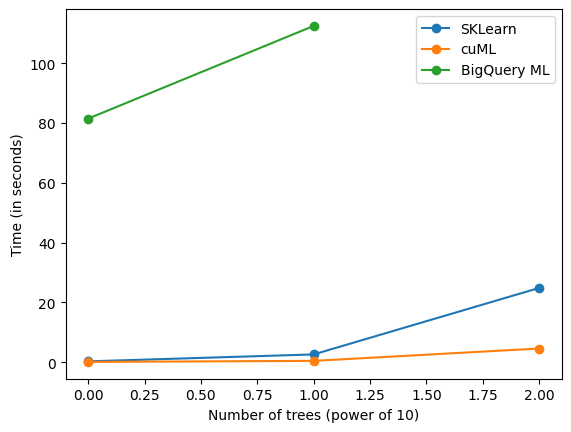

In [326]:
plt.plot(sk_time, marker='o', label='SKLearn')
plt.plot(rapid_time, marker='o', label='cuML')
plt.plot(bigml_time, marker='o', label='BigQuery ML')
plt.legend()
plt.xlabel('Number of trees (power of 10)')
plt.ylabel('Time (in seconds)')

plt.savefig("train_time.svg", format='svg', bbox_inches='tight')

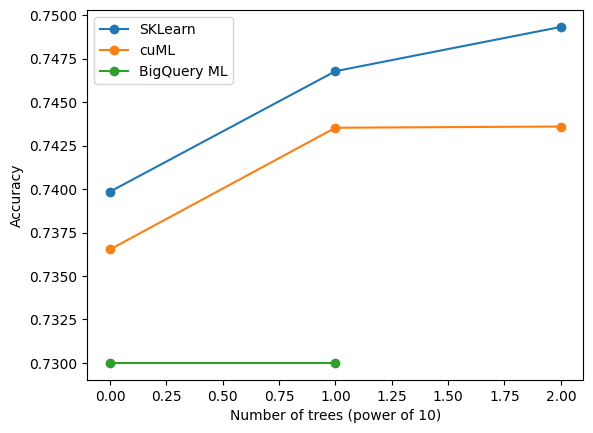

In [327]:
plt.plot(sk_acc, marker='o', label='SKLearn')
plt.plot(rapid_acc, marker='o', label='cuML')
plt.plot(bigml_acc, marker='o', label='BigQuery ML')
plt.legend()
plt.xlabel('Number of trees (power of 10)')
plt.ylabel('Accuracy')

plt.savefig("accuracy.svg", format='svg', bbox_inches='tight')